## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Столбец date имеет тип данных 'object'

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'])
daily_data_a = data[data['group'] == 'A'].groupby('date').agg('count').reset_index()
daily_data_b = data[data['group'] == 'B'].groupby('date').agg('count').reset_index()
print(data['date'].min(), data['date'].max())
print(daily_data_a['date'].min() == daily_data_b['date'].min())
print(daily_data_a['date'].max() == daily_data_b['date'].max())

2021-01-02 00:00:00 2021-01-24 00:00:00
True
True


Длительность проведения тестирования для каждой из группы равна, и проводилась в промежуток со 2 по 24 января 2021 года.

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
print('Количество посещений сайта в группе А:', data[data['group'] == 'A'].shape[0])
print('Количество посещений сайта в группе B:', data[data['group'] == 'B'].shape[0])
print('Суммарное количество покупок в группе А:', data[data['group'] == 'A']['purchase'].sum())
print('Суммарное количество покупок в группе B:', data[data['group'] == 'B']['purchase'].sum())
print('Сумма всех покупок в группе А:', round(data[data['group'] == 'A']['price'].sum() / 1000000, 2))
print('Сумма всех покупок в группе B:', round(data[data['group'] == 'B']['price'].sum() / 1000000, 2))

Количество посещений сайта в группе А: 147202
Количество посещений сайта в группе B: 147276
Суммарное количество покупок в группе А: 17723
Суммарное количество покупок в группе B: 17514
Сумма всех покупок в группе А: 1436.26
Сумма всех покупок в группе B: 1554.1


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
set_a = set(data[data['group'] == 'A']['user_id'])
set_b = set(data[data['group'] == 'B']['user_id'])
set_intersection = set_a.intersection(set_b)
print('Количество пользователей, попавших в обе тестовые группы:', len(set_intersection))

Количество пользователей, попавших в обе тестовые группы: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
data = data[data['user_id'].apply(lambda x: x not in set_intersection)]

Где set_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

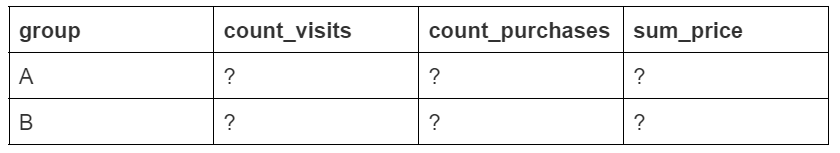
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
count_data = data.groupby('group').agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
count_data

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество посещений и количество покупок в обоих группах сопоставимо, выборки сбалансированы.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
count_data['conversion'] = round(count_data['count_purchases'] / count_data['count_visits'] * 100, 2)
count_data['mean_check'] = round(count_data['sum_price'] / count_data['count_purchases'])
count_data

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Конверсия в группе А немного выше, чем в группе В, но средний чек меньше.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
pivot_data = data[data['price'] > 0].pivot_table(
    index='group',
    columns='price',
    values='purchase',
    aggfunc='sum')
pivot_data

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

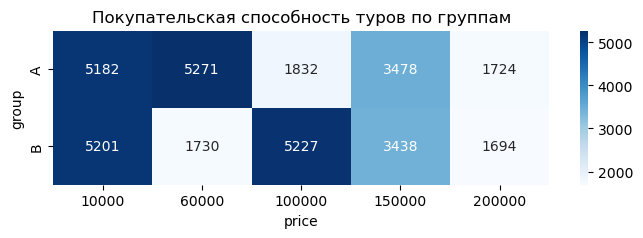

In [11]:
fig = plt.figure(figsize=(8, 2))
ax = sns.heatmap(pivot_data, fmt='.0f', annot=True, cmap='Blues')
ax.set_title('Покупательская способность туров по группам');

В группе А количество проданных туров за шестьдесят тысяч рублей - 5271, в группе В - 1730.

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Покупательская способность участников группы А выше, чем участников группы B в турах за шестьдесят тысяч рублей, но меньше в турах за сто тысяч рублей. По остальным ценам группы сопоставимы.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [38]:
count_data = data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

count_data['conversion'] = round(count_data['count_purchases'] / count_data['count_visits'] * 100, 2)
count_data['mean_check'] = round(count_data['sum_price'] / count_data['count_purchases'])

print('Конверсия 3 января 2021 года:\n', count_data[count_data['date'] == '2021-01-03'][['group', 'conversion']])
print('Средний чек 3 января 2021 года:\n', count_data[count_data['date'] == '2021-01-03'][['group', 'mean_check']])

Конверсия 3 января 2021 года:
   group  conversion
2     A       11.34
3     B       11.39
Средний чек 3 января 2021 года:
   group  mean_check
2     A     82888.0
3     B     87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [44]:
count_data['count_visits_cum'] = count_data.groupby(['group'])['count_visits'].cumsum()
count_data['count_purchases_cum'] = count_data.groupby(['group'])['count_purchases'].cumsum()
count_data['sum_price_cum'] = count_data.groupby(['group'])['sum_price'].cumsum()

count_data['conversion_cum'] = round(count_data['count_purchases_cum'] / count_data['count_visits_cum'] * 100, 2)
count_data['mean_check_cum'] = round(count_data['sum_price_cum'] / count_data['count_purchases_cum'])

print('Кумулятивная конверсия 20 января 2021 года:\n', 
      count_data[count_data['date'] == '2021-01-20'][['group', 'conversion_cum']])
print('Кумулятивная средний чек 12 января 2021 года:\n', 
      count_data[count_data['date'] == '2021-01-12'][['group', 'mean_check_cum']])

Кумулятивная конверсия 20 января 2021 года:
    group  conversion_cum
36     A           11.98
37     B           11.90
Кумулятивная средний чек 12 января 2021 года:
    group  mean_check_cum
20     A         81492.0
21     B         88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

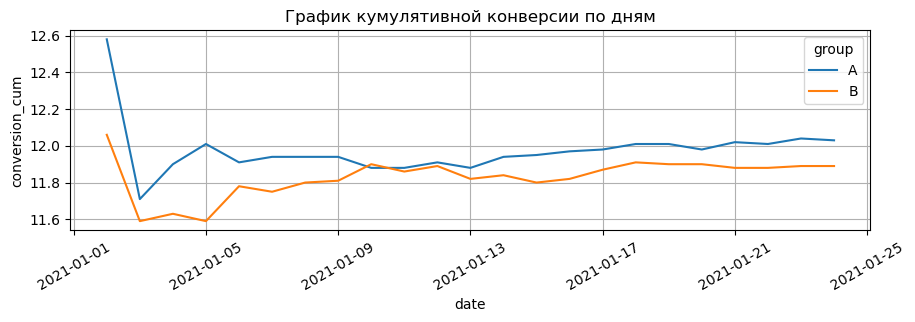

In [48]:
fig = plt.figure(figsize=(8, 2))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='conversion_cum', data=count_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 30)
ax.grid(True);

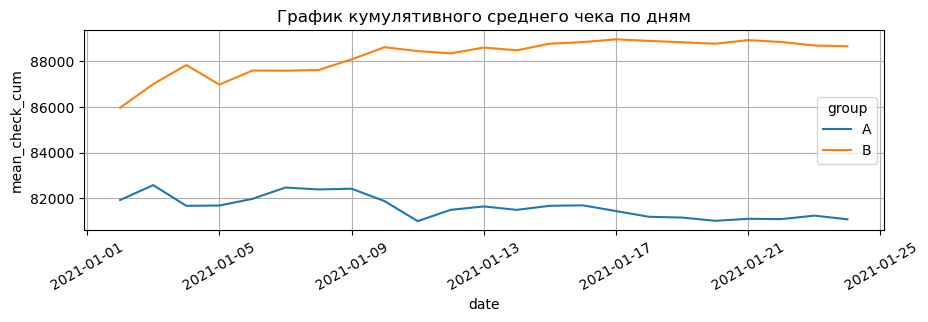

In [51]:
fig = plt.figure(figsize=(8, 2))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='mean_check_cum', data=count_data, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 30)
ax.grid(True);

Значение метрик стабилизировались во времени для каждого из показателей. 
Кумулятивная конверсия выше в группе А, а вот кумулятивный средний чек выше в группе В.
А/В тест завершенным назвать нельзя, так как необходимо провести статистический анализ результатов. 

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [58]:
converted_piv = data.groupby('group')['purchase'].agg(
    ['sum', 'count'])

H0 = 'Конверсии в группах А и B равны.'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B.'
alpha = 0.05

_, p_value = proportions_ztest(
    count = converted_piv['sum'],
    nobs = converted_piv['count'],
    alternative='larger')
print('p-value: ', round(p_value, 2))

if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны.


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Принимаем нулевую гипотезу. Конверсии в группах А и B равны.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [16]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [17]:
# ваш код здесь

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [18]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [19]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 